Davin Edbert Santoso Halim
/ 2602067086

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, Dropout
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.optimizers import RMSprop

In [ ]:
# Memuat dataset fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
# Menggabungkan data train dan test
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

In [ ]:
# Menampilkan beberapa contoh dari setiap kelas
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

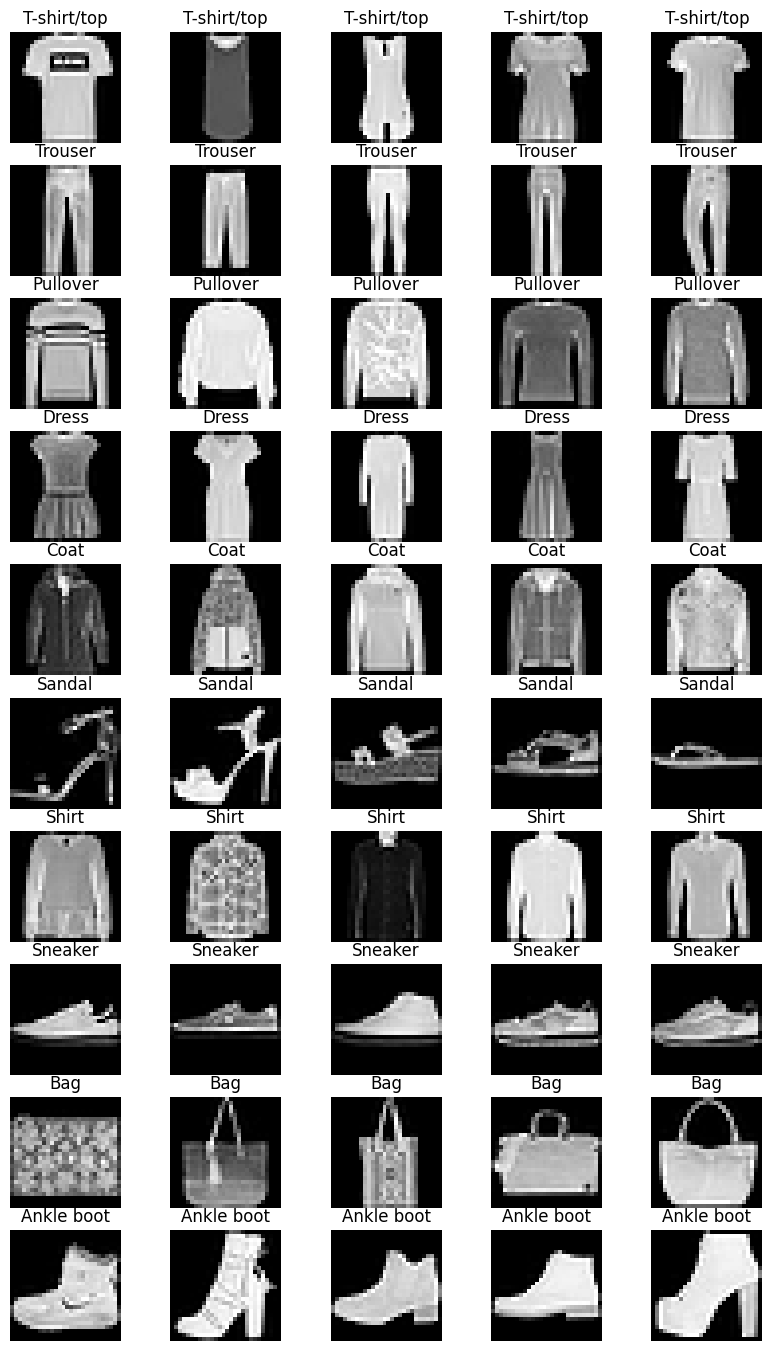

In [ ]:
plt.figure(figsize=(10, 17))
num_images_per_class = 5  # Jumlah gambar per kelas
for class_id in range(10):
    # Ambil gambar pertama dari setiap kelas
    class_indices = np.where(all_labels == class_id)[0]
    for i in range(num_images_per_class):
        plt.subplot(10, num_images_per_class, class_id * num_images_per_class + i + 1)
        plt.imshow(all_images[class_indices[i]], cmap='gray')
        plt.title(class_names[class_id])
        plt.axis('off')

plt.show()

In [ ]:
# Mengambil hanya kelas T-shirt/top (0) dan Trouser (1)
# sesuai gender dan nim
selected_indices = np.where((all_labels == 0) | (all_labels == 1))
filtered_images = all_images[selected_indices]
filtered_labels = all_labels[selected_indices]

**Preprocessing Data**
1. Normalization: Ini mengubah tipe data menjadi float32 dan menormalkan nilai piksel dari rentang [0, 255] menjadi [0, 1]. Normalisasi penting untuk stabilitas pelatihan karena jaringan neural cenderung berperforma lebih baik dengan input yang memiliki skala nilai yang lebih kecil dan seragam.
2. Expanding Dimensions: Ini menambahkan satu dimensi tambahan ke array, mengubah bentuknya dari (28, 28) menjadi (28, 28, 1). Langkah ini diperlukan karena banyak arsitektur jaringan convolutional, mengharapkan input dengan tiga dimensi (height, width, channels), bahkan jika gambar tersebut grayscale (memiliki satu channel).



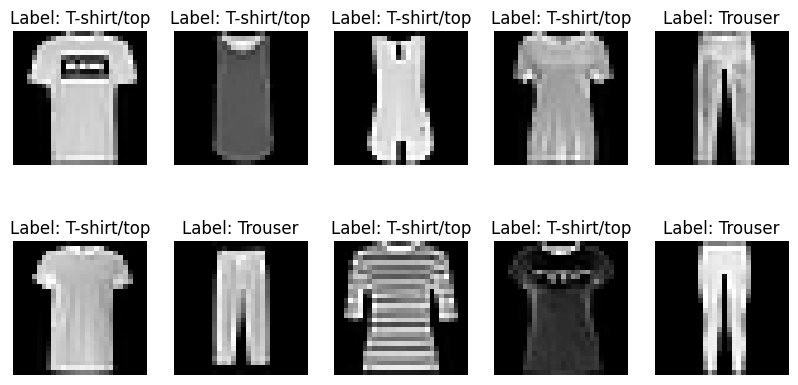

In [ ]:
# Mengubah label menjadi teks
label_names = {0: 'T-shirt/top', 1: 'Trouser'}
filtered_labels = np.vectorize(label_names.get)(filtered_labels)

# Melakukan rescaling dan mengonversi tipe data menjadi float32
filtered_images = filtered_images.astype('float32') / 255.0
filtered_images = np.expand_dims(filtered_images, -1)

# Menampilkan contoh data
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(filtered_images[i], cmap='gray')
    plt.title(f'Label: {filtered_labels[i]}')
    plt.axis('off')
plt.show()

**Splitting**

Melakukan Splitting 80% train, 10% val, 10% test

In [ ]:
# Membagi dataset menjadi training set (80%), validation set (10%), dan test set (10%)
train_images, temp_images, train_labels, temp_labels = train_test_split(filtered_images, filtered_labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

# Menampilkan bentuk data untuk memastikan semuanya sudah benar
print(f'Train images shape: {train_images.shape}')
print(f'Validation images shape: {val_images.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (11200, 28, 28, 1)
Validation images shape: (1400, 28, 28, 1)
Test images shape: (1400, 28, 28, 1)
Train labels shape: (11200,)
Validation labels shape: (1400,)
Test labels shape: (1400,)


In [ ]:
# Membuat arsitektur Autoencoder
input_img = Input(shape=(28, 28, 1))

Input layer menerima gambar grayscale dengan ukuran 28x28 piksel dan 1 channel.


Encoder:
- Convolutional Layer: Layer ini memiliki 32 filter dengan ukuran kernel 3x3, menggunakan aktivasi ReLU, dan padding 'same' untuk mempertahankan ukuran output yang sama dengan input
- MaxPooling Layer: Layer pooling ini mengurangi ukuran fitur map dari 28x28 menjadi 14x14 menggunakan pooling window 2x2 dengan padding 'same'.
- Flatten Layer: Mengubah tensor 3D (14, 14, 32) menjadi vektor 1D dengan ukuran 6272.
- Dense Layer: Layer ini mengandung 6272 neuron dengan aktivasi ReLU.
- Encoded Layer: Layer ini mengkompres data menjadi representasi dengan 128 neuron (encoding).

In [ ]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(6272, activation='relu')(x)
encoded = Dense(128, activation='relu')(x)

# Decoder
x = Dense(6272, activation='relu')(encoded)
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)  # Mengembalikan ukuran menjadi 28x28 dari 14x14
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Mengembalikan ukuran tetap 28x28

Decoder:

-Dense Layer: Layer ini memperbesar kembali vektor 128 menjadi 6272 neuron dengan aktivasi ReLU.
- Reshape Layer: Mengubah kembali vektor 1D menjadi tensor 3D dengan ukuran 14x14x32.
- UpSampling Layer: Layer ini mengembalikan ukuran tensor dari 14x14 menjadi 28x28 menggunakan metode upsampling dengan faktor 2.
- Convolutional Layer: Convolutional layer ini dengan 32 filter, kernel 3x3, aktivasi ReLU, dan padding 'same' memperhalus hasil upsampling.
- Output Layer: Layer akhir dengan 1 filter, kernel 3x3, aktivasi sigmoid, dan padding 'same' menghasilkan output gambar dengan ukuran 28x28 dan 1 channel, sesuai dengan input asli.











In [ ]:
# Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Training:

- history adalah objek yang menyimpan hasil pelatihan model, termasuk nilai loss dan metrik lainnya untuk setiap epoch. Ini berguna untuk analisis dan visualisasi setelah pelatihan selesai.
- epochs=30:
- batch_size=256: Ukuran batch atau jumlah sampel yang diproses sebelum model diperbarui. Menggunakan batch size 256 berarti model diperbarui setelah melihat 256 sampel.
- shuffle=True:Data akan diacak sebelum setiap epoch pelatihan untuk membantu model belajar lebih baik dan menghindari pola yang dapat menyebabkan overfitting.

In [ ]:
# Melatih model
history = autoencoder.fit(train_images, train_images,
                          epochs=30,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(val_images, val_images))

Epoch 1/30
44/44 [==============================] - 6s 55ms/step - loss: 0.3733 - val_loss: 0.3130
Epoch 2/30
44/44 [==============================] - 2s 39ms/step - loss: 0.2962 - val_loss: 0.2867
Epoch 3/30
44/44 [==============================] - 2s 39ms/step - loss: 0.2765 - val_loss: 0.2742
Epoch 4/30
44/44 [==============================] - 2s 37ms/step - loss: 0.2668 - val_loss: 0.2673
Epoch 5/30
44/44 [==============================] - 2s 38ms/step - loss: 0.2614 - val_loss: 0.2641
Epoch 6/30
44/44 [==============================] - 2s 38ms/step - loss: 0.2582 - val_loss: 0.2610
Epoch 7/30
44/44 [==============================] - 2s 38ms/step - loss: 0.2556 - val_loss: 0.2588
Epoch 8/30
44/44 [==============================] - 2s 38ms/step - loss: 0.2538 - val_loss: 0.2572
Epoch 9/30
44/44 [==============================] - 2s 39ms/step - loss: 0.2520 - val_loss: 0.2560
Epoch 10/30
44/44 [==============================] - 2s 40ms/step - loss: 0.2509 - val_loss: 0.2553
Epoch 11/

In [ ]:
decoded_images = autoencoder.predict(test_images)

44/44 [==============================] - 0s 5ms/step


In [ ]:
# Evaluasi menggunakan SSIM
ssim_scores = []
for i in range(len(test_images)):
    score = ssim(test_images[i].squeeze(), decoded_images[i].squeeze(), data_range=decoded_images[i].max() - decoded_images[i].min())
    ssim_scores.append(score)

average_ssim = np.mean(ssim_scores)
print(f'Average SSIM: {average_ssim}')

Average SSIM: 0.8735923887214739


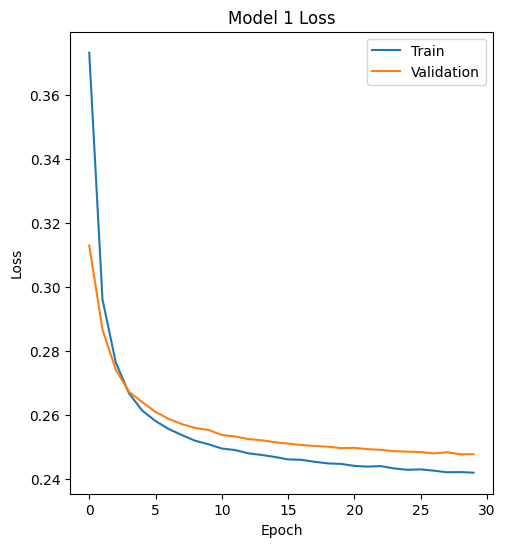

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Jika model juga mengukur accuracy
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


**Plot Loss Model 1**
- Training Loss: Menurun bertahap dan stabil pada 0.24 setelah 25-30 epoch.
- Validation Loss: Menurun dengan pola mirip training loss, menunjukkan tidak ada overfitting signifikan.

Sudah stabil dan tidak overfitting.

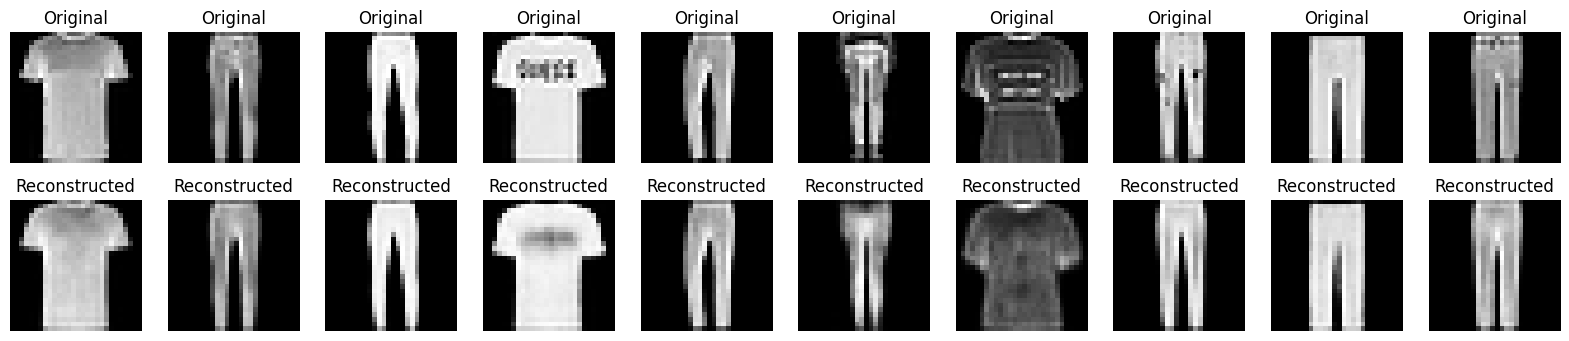

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Decoded images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

Plot ini menunjukkan perbandingan langsung antara gambar asli (Original) dan gambar yang direkonstruksi (Reconstructed) oleh Autoencoder, membantu dalam mengevaluasi kualitas rekonstruksi yang dihasilkan oleh model.

Hasil visualisasi menunjukkan bahwa Autoencoder berhasil merekonstruksi gambar dengan baik, mempertahankan bentuk dan pola umum dari gambar asli. Meskipun beberapa gambar rekonstruksi tampak buram dan kehilangan detail, secara keseluruhan model mampu menangkap fitur utama. Ini menunjukkan bahwa model memiliki kemampuan generalisasi yang baik, meski ada ruang untuk perbaikan dalam menangkap detail yang lebih halus.

# FINE TUNE

### ENCODER

1. BatchNormalization:
- Tujuan: Menormalkan output dari layer sebelumnya sehingga distribusi aktivasi tetap stabil selama pelatihan.
- Manfaat: Mempercepat konvergensi model, membuat pelatihan lebih stabil dengan mengurangi masalah yang disebabkan oleh perubahan distribusi aktivasi di setiap layer

2. MaxPooling2D (with padding='same'):
- Tujuan: Mengurangi dimensi spasial (height dan width) dari data, sambil mempertahankan informasi penting.
- Manfaat: Mengurangi jumlah parameter dalam model, yang dapat membantu mencegah overfitting, mempercepat komputasi dengan mengurangi ukuran data.

3. Dropout:
- Tujuan: Mengabaikan (drop) secara acak sejumlah neuron selama pelatihan untuk mencegah overfitting.
- Manfaat: Mengurangi overfitting dengan membuat model lebih robust, memaksa jaringan untuk tidak terlalu bergantung pada neuron tertentu, yang meningkatkan generalisasi.

4. Penambahan Lapisan Konvolusi Tambahan:
- Tujuan: Menambah kedalaman jaringan dengan lapisan konvolusi 64 dan 128 filter untuk menangkap fitur yang lebih kompleks.
- Manfaat: Meningkatkan kapasitas model untuk mengenali pola yang lebih rumit dan detail dalam data.

5. Penggunaan Tiga Lapisan Konvolusi dengan Ukuran Filter yang Berbeda:
- Tujuan: Menangkap berbagai tingkatan fitur dari data input.
- Manfaat: Membantu model memahami data dengan lebih baik, dari fitur dasar hingga fitur kompleks.

### DECODER

1. Perubahan Struktur Dense Layer:
- Tujuan: Mengubah ukuran Dense layer dari 6272 menjadi 7 * 7 * 64.
- Manfaat: Memampatkan informasi secara lebih efisien dan sesuai dengan ukuran fitur map yang lebih kecil.

2. Perubahan Reshape Layer:
- Tujuan: Mengubah dimensi tensor dari (14, 14, 32) menjadi (7, 7, 64).
- Manfaat: Menyesuaikan dengan ukuran fitur map yang dihasilkan oleh encoder yang lebih dalam.

3. Penambahan UpSampling2D Layer:
- Tujuan: Menambah dua lapisan upsampling untuk meningkatkan dimensi spasial secara bertahap.
- Manfaat: Mengembalikan ukuran fitur map ke ukuran aslinya (28x28) secara bertahap, menjaga informasi lebih baik.

4. Penambahan Lapisan Konvolusi Tambahan:
- Tujuan: Menambah lapisan konvolusi dengan 128, 64, dan 32 filter.
- Manfaat: Meningkatkan kemampuan model untuk menangkap detail dan fitur kompleks selama proses dekoding.

5. Penambahan Batch Normalization:
- Tujuan: Menormalkan output dari lapisan konvolusi.
- Manfaat: Mempercepat pelatihan dan meningkatkan stabilitas jaringan.

In [ ]:
input_img_2 = Input(shape=(28, 28, 1))

x_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img_2)
x_2 = BatchNormalization()(x_2)
x_2 = MaxPooling2D((2, 2), padding='same')(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = MaxPooling2D((2, 2), padding='same')(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = MaxPooling2D((2, 2), padding='same')(x_2)
x_2 = Flatten()(x_2)
x_2 = Dense(7 * 7 * 64, activation='relu')(x_2)
encoded_2 = Dense(128, activation='relu')(x_2)

x_2 = Dense(7 * 7 * 64, activation='relu')(encoded_2)
x_2 = Reshape((7, 7, 64))(x_2)
x_2 = UpSampling2D((2, 2))(x_2)
x_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = UpSampling2D((2, 2))(x_2)
x_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_2)
x_2 = BatchNormalization()(x_2)
decoded_2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x_2)

# Model
autoencoder_2 = Model(input_img_2, decoded_2)
autoencoder_2.compile(optimizer='nadam', loss='binary_crossentropy')  # Menggunakan optimizer Nadam


Alasan Mengganti Optimizer dari Adam ke Nadam:
1. Penggabungan Teknik:
Nadam menggabungkan adaptasi learning rate dari Adam dengan momentum Nesterov, sehingga memanfaatkan kelebihan kedua teknik tersebut.

2. Konvergensi Lebih Cepat:
Nadam dapat mencapai konvergensi lebih cepat dibandingkan Adam, sehingga mengurangi waktu yang diperlukan untuk pelatihan model.

3. Stabilitas Pelatihan yang Lebih Baik:
Dengan menggunakan momentum Nesterov, Nadam memberikan pembaruan gradien yang lebih hati-hati, menghindari overshooting dan meningkatkan stabilitas selama pelatihan.

4. Akurasi Lebih Baik:
Kombinasi adaptasi learning rate dan momentum Nesterov dalam Nadam sering kali menghasilkan akurasi yang lebih tinggi dibandingkan Adam.

5. Peningkatan Generalisasi:
Nadam membantu model untuk generalisasi lebih baik pada data yang tidak terlihat, sehingga mengurangi risiko overfitting dan membuat model lebih rob

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

menggunakan LearningRateScheduler dari Keras untuk menyesuaikan learning rate selama pelatihan model. Fungsi scheduler mempertahankan learning rate tetap selama 10 epoch pertama, kemudian menguranginya secara eksponensial setelah itu. Dengan cara ini, model memulai dengan learning rate yang lebih tinggi untuk cepat mendekati solusi, lalu mengurangi learning rate untuk stabilitas konvergensi. LearningRateScheduler diterapkan sebagai callback dalam pelatihan untuk otomatis mengatur perubahan learning rate sesuai fungsi yang ditentukan.

model autoencoder_2 dilatih dengan parameter yang telah disesuaikan:

1. epochs=50: Jumlah epoch ditingkatkan menjadi 50.
- Tujuan: Memberi model lebih banyak waktu untuk belajar dari data dan meningkatkan performa.
- Manfaat: Potensi untuk mencapai konvergensi yang lebih baik dan meningkatkan akurasi.

2. batch_size=128: Ukuran batch diubah menjadi 128.
- Tujuan: Mengubah batch size untuk menyeimbangkan antara kecepatan pelatihan dan stabilitas gradien.
- Manfaat: Batch size yang lebih kecil dapat memberikan gradien yang lebih stabil dan memungkinkan model belajar dengan lebih detail dari setiap batch.

3. callbacks=[lr_scheduler]: Penambahan callback lr_scheduler.
- Tujuan: Menggunakan Learning Rate Scheduler untuk menyesuaikan learning rate selama pelatihan.
- Manfaat:Menghindari learning rate yang terlalu tinggi yang bisa menyebabkan overshootingdan menghindari learning rate yang terlalu rendah yang bisa menyebabkan pelatihan lambat atau terjebak di local minima.

In [ ]:
# Melatih model dengan learning rate scheduler
history_2 = autoencoder_2.fit(train_images, train_images,
                              epochs=50,  # Menambah jumlah epoch
                              batch_size=128,  # Mengubah batch size
                              shuffle=True,
                              validation_data=(val_images, val_images),
                              callbacks=[lr_scheduler])

# Menghasilkan citra hasil decoder untuk data test
decoded_images_2 = autoencoder_2.predict(test_images)

# Menghitung SSIM
ssim_scores_2 = []
for i in range(len(test_images)):
    score_2 = ssim(test_images[i].squeeze(), decoded_images_2[i].squeeze(), data_range=decoded_images_2[i].max() - decoded_images_2[i].min())
    ssim_scores_2.append(score_2)

average_ssim_2 = np.mean(ssim_scores_2)
print(f'Average SSIM after further tuning: {average_ssim_2}')


Epoch 1/50
88/88 [==============================] - 14s 54ms/step - loss: 0.3492 - val_loss: 0.5645 - lr: 0.0010
Epoch 2/50
88/88 [==============================] - 4s 42ms/step - loss: 0.2698 - val_loss: 0.5488 - lr: 0.0010
Epoch 3/50
88/88 [==============================] - 4s 43ms/step - loss: 0.2594 - val_loss: 0.4876 - lr: 0.0010
Epoch 4/50
88/88 [==============================] - 4s 43ms/step - loss: 0.2550 - val_loss: 0.3875 - lr: 0.0010
Epoch 5/50
88/88 [==============================] - 4s 42ms/step - loss: 0.2528 - val_loss: 0.3064 - lr: 0.0010
Epoch 6/50
88/88 [==============================] - 4s 42ms/step - loss: 0.2509 - val_loss: 0.2777 - lr: 0.0010
Epoch 7/50
88/88 [==============================] - 4s 44ms/step - loss: 0.2496 - val_loss: 0.2588 - lr: 0.0010
Epoch 8/50
88/88 [==============================] - 4s 43ms/step - loss: 0.2486 - val_loss: 0.2529 - lr: 0.0010
Epoch 9/50
88/88 [==============================] - 4s 43ms/step - loss: 0.2478 - val_loss: 0.2540 - lr

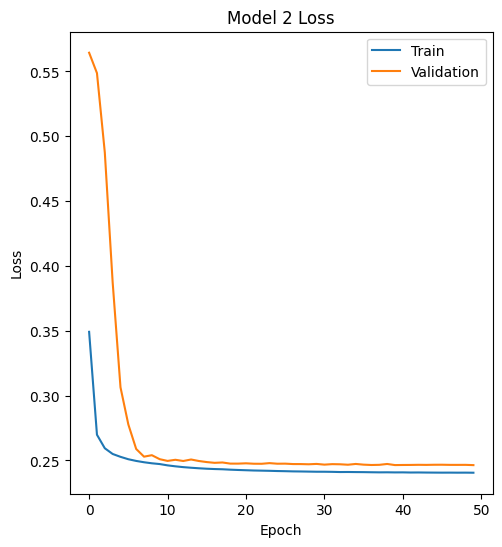

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

**Plot Loss Model 2**
- Training Loss: Menurun cepat dan stabil di sekitar 0.25 setelah 10 epoch.
- Validation Loss: Menurun cepat dan tetap dekat dengan training loss, menunjukkan tidak ada overfitting.

Lebih cepat belajar dan lebih stabil, berkat batch normalization dan learning rate scheduler.

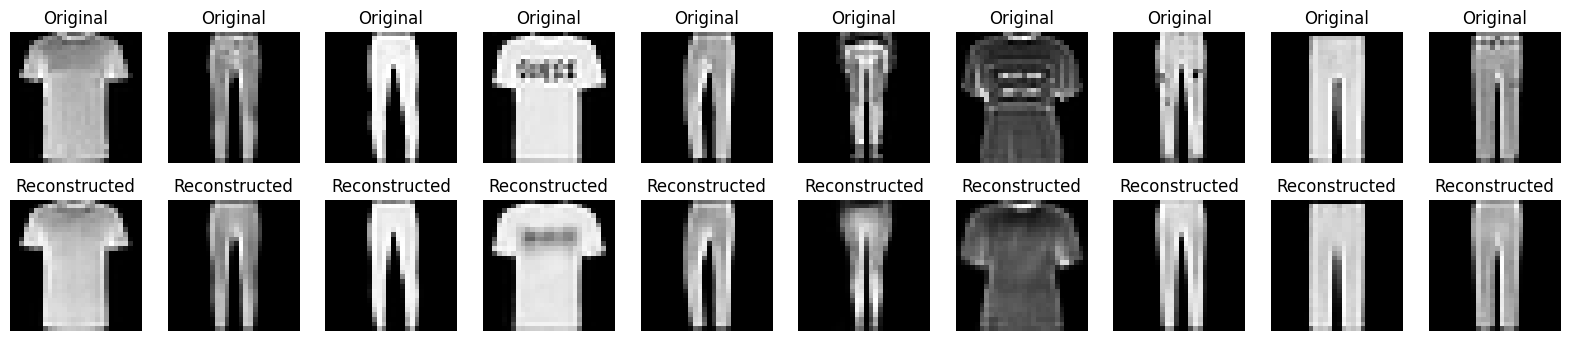

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Decoded images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images_2[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()


Sebagian besar gambar rekonstruksi berhasil mempertahankan bentuk dan struktur umum dari gambar asli, meskipun beberapa detail tampak buram atau hilang. Ini menunjukkan bahwa Autoencoder mampu menangkap fitur utama dari gambar input,

# EVALUATION

**Model 1:**
- Average SSIM: 0.8736
- Training Loss: Menurun secara stabil dan stabil di sekitar 0.24 setelah 25-30 epoch.
- Validation Loss: Juga menurun secara stabil dan tetap dekat dengan training loss, menunjukkan tidak adanya overfitting yang signifikan.

**Model 2:**
- Average SSIM setelah tuning: 0.8833
- Training Loss: Menurun dengan cepat dan stabil di sekitar 0.25 setelah 10 epoch.
- Validation Loss: Menurun dengan cepat dan stabil, tetap dekat dengan training loss, menunjukkan tidak adanya overfitting yang signifikan.

# ALASAN KENAPA LEBIH BAIK

**1. Penambahan Lapisan Konvolusi dan Batch Normalization**
- Alasan: Model 2 menambahkan lebih banyak lapisan konvolusi dan batch normalization untuk menangkap lebih banyak fitur dan menormalkan output.
- Keuntungan: Memungkinkan model untuk belajar representasi yang lebih kompleks dan stabil, menghasilkan rekonstruksi gambar yang lebih akurat.

**2. Penggunaan Dropout**
- Alasan: Dropout digunakan untuk mencegah overfitting dengan menonaktifkan neuron secara acak selama pelatihan.
- Keuntungan: Membuat model lebih robust dan mampu generalisasi lebih baik dibandingkan Model 1 yang tidak menggunakan dropout.

**3. Peningkatan Jumlah Unit dalam Lapisan Dense**
- Alasan: Model 2 meningkatkan jumlah unit dalam lapisan Dense untuk menangkap lebih banyak informasi.
- Keuntungan: Membantu dalam menyimpan lebih banyak informasi penting dari lapisan konvolusi, meningkatkan akurasi rekonstruksi.

**4. Penggunaan Optimizer Nadam dan Learning Rate Scheduler**
- Alasan: Nadam menggabungkan kelebihan RMSprop dan Adam dengan momentum Nesterov, sedangkan learning rate scheduler mengurangi learning rate secara bertahap.
- Keuntungan: Mempercepat konvergensi, meningkatkan stabilitas, dan mengurangi risiko overfitting, menghasilkan model yang lebih baik dalam belajar dan merekonstruksi gambar.

# KESIMPULAN

Modifikasi pada Model 2:
- Menangkap lebih banyak fitur dari gambar melalui lapisan konvolusi tambahan dan batch normalization.
- Mencegah overfitting dengan penggunaan dropout.
- Meningkatkan kapasitas penyimpanan informasi dengan menambah unit pada lapisan Dense.
- Mempercepat dan menstabilkan pelatihan dengan optimizer Nadam dan learning rate scheduler.

Hasilnya, Model 2 menghasilkan average SSIM yang lebih tinggi (0.8833) dibandingkan Model 1 (0.8736), menunjukkan bahwa
rekonstruksi gambar lebih akurat dan mendekati gambar asli.

FOLDER VIDEO:

https://drive.google.com/drive/folders/1xqjdupi1iiNEGL7FXW0lVIbF4yBO-Yap?usp=drive_link

LINK CODE NO 1 (COLLAB):

https://colab.research.google.com/drive/1-mf7uwgtoidDlSb9HvNN6yhmnyD9Uent#scrollTo=3DJpZU9B1xMo

LINK CODE NO 2 (COLLAB):

https://colab.research.google.com/drive/1m-zM99EvRIIzz1Pmh_eXewD0yLtoi9fO#scrollTo=LQjAJ3GZ8S1w

LINK CODE NO 3 (COLLAB):

https://colab.research.google.com/drive/1AqZXrCweHM1jTqAxYJnP7B-zHojKVQ1I#scrollTo=Rh5_uFY1yG9H